In [41]:
import sys
import numpy as np
import pandas as pd
# from matplotlib.pyplot import imread
from skimage.io import imread
from skimage.transform import resize
from skimage import util 

import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from time import time
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
import keras.layers as layers
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng
from keras.utils import plot_model
from deepcapsulelayers import Conv2DCaps, ConvCapsuleLayer3D, CapsuleLayer, CapsToScalars, Mask_CID, ConvertToCaps, FlattenCaps
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
from time import time
import glob
from IPython.display import Image
from keras.datasets import mnist
import uuid
from random import randrange


In [2]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [3]:
_, (x_test_mnist, y_test_mnist) = mnist.load_data()

In [4]:
img_path_map = {}
for i in range(10):
    img_path_map[i] = x_test_mnist[np.where(y_test_mnist == i)]

In [5]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in ['mnist']:
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
#         alphabet_path = os.path.join(path,alphabet)
        # every letter/category has it's own column in the array, so  load seperately
        for letter in [i for i in range(10)]:
            cat_dict[curr_y] = (alphabet, str(letter))
            category_images=[]
#             letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for file in [im for im in img_path_map[letter]]:
                image = file
                image = resize(image, (105, 105))
                image = util.invert(image)
                image = image - 0.5
                category_images.append(image)
                y.append(curr_y)
                if (len(category_images) == 100):
                    break
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

In [8]:
# X,y,c=loadimgs('')
# save_path = 'mnist_data'
# with open(os.path.join(save_path,"test.pickle"), "wb") as f:
#     pickle.dump((X,c),f)

In [20]:
np.average(X)

0.3754702464950428

## Loading Omniglot

In [6]:
train_folder = "data/images_background/"
val_folder = 'data/images_evaluation/'
save_path = 'data/'
train_type = 'capsule_rev2' #CONVOLUTIONAL or CAPSULE

In [7]:
with open(os.path.join('mnist_data', "test.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
print("Test alphabets: \n")
print(list(train_classes.keys()))


Test alphabets: 

['mnist']


In [23]:
# with open(os.path.join(save_path, "train.pickle"), "rb") as f:
#     (Xtrain, train_classes) = pickle.load(f)
    
# print("Training alphabets: \n")
# print(list(train_classes.keys()))

# with open(os.path.join(save_path, "val.pickle"), "rb") as f:
#     (Xval, val_classes) = pickle.load(f)

# print("Validation alphabets:", end="\n\n")
# print(list(val_classes.keys()))

In [9]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

In [10]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [11]:
train_classes

{'mnist': [0, 9]}

In [12]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low + 1:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [13]:

true_category = 1
true_image_index = 10
def make_oneshot_task_simplified(true_category, true_image_index, N):
    X = Xtrain
    n_classes, n_examples, w, h = X.shape

    categories = [0,1,2,3,4,5,6,7,8,9]


    indices = rng.randint(0, n_examples,size=(N,))
    support_set = X[categories,indices,:,:]
    support_set = support_set.reshape(N, w, h,1)
    test_image = np.asarray([X[true_category,true_image_index,:,:]]*N).reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[true_category] = 1
#     targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]
    return pairs, targets

## Get Siamese Models

In [14]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [15]:
conv_model = get_siamese_model((105, 105, 1))

latest_ckpt = 'checkpoints_convolutional/siamese-epoch-00340-lr--train_loss-0.1779-val_loss-0.3052.hdf5'
print("loading from checkpoint: ", latest_ckpt)
conv_model.load_weights(latest_ckpt)



W0803 08:51:49.666222 4794652096 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 08:51:49.686358 4794652096 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 08:51:49.708271 4794652096 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0803 08:51:52.499226 4794652096 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0803 08:51:52.636509 4794652096 deprecation_wrapper.py:119] From /usr/loca

loading from checkpoint:  checkpoints_convolutional/siamese-epoch-00340-lr--train_loss-0.1779-val_loss-0.3052.hdf5


## Get Capsule Models

In [16]:
def BaseCapsNet(input_shape, n_class, routings):
    # assemble encoder
    x = Input(shape=input_shape)
    l = x

    l = Conv2D(256, (9, 9), strides=(5,5), activation='relu', padding="same")(l) 
    l = BatchNormalization()(l)
    l = ConvertToCaps()(l)
    
    l = Conv2DCaps(32, 4, kernel_size=(3, 3), strides=(2, 2), r_num=1, b_alphas=[1, 1, 1])(l)
    l = Conv2DCaps(32, 4, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1])(l)
    l = Conv2DCaps(32, 4, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1])(l)
    l = Conv2DCaps(16, 6, kernel_size=(3, 3), strides=(2, 2), r_num=1, b_alphas=[1, 1, 1])(l)
    
    l = FlattenCaps()(l)
    
    digits_caps = CapsuleLayer(num_capsule=20, dim_capsule=16, routings=routings, channels=0, name='digit_caps')(l)
#     l = CapsToScalars(name='capsnet')(digits_caps)

    m_capsnet = Model(inputs=x, outputs=digits_caps, name='capsnet_model')
    

    return m_capsnet

In [17]:
def get_capsnet_model(input_shape, n_class, routings):

    left_input = Input(shape=input_shape)
    right_input = Input(shape=input_shape)

    tunnel = BaseCapsNet(input_shape, n_class, routings)
    tunnel.summary()
    encoded_l = tunnel(left_input)
    encoded_r = tunnel(right_input)

    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    L1_distance = Flatten()(L1_distance)
    
    prediction = Dense(1024, activation='relu', bias_initializer=initialize_bias)(L1_distance)
    prediction = Dense(256, activation='relu', bias_initializer=initialize_bias)(prediction)
    prediction = Dense(32, activation='relu', bias_initializer=initialize_bias)(prediction)
    prediction = Dense(1, activation='sigmoid', bias_initializer=initialize_bias)(prediction)

    train_model = Model(inputs=[left_input, right_input], outputs=prediction)

    return train_model


In [18]:

cap_model = get_capsnet_model(input_shape=[105, 105, 1], n_class=10, routings=3)

latest_ckpt = 'checkpoints_capsule_rev2_fix2/siamese-epoch-00111-lr--train_loss-0.0876-val_loss-0.1711.hdf5'
print("loading from checkpoint: ", latest_ckpt)
cap_model.load_weights(latest_ckpt)

cap_model.summary()

optimizer = Adam(lr = 0.00001)
cap_model.compile(loss="binary_crossentropy",optimizer=optimizer)



W0803 08:52:00.520763 4794652096 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0803 08:52:00.783366 4794652096 deprecation.py:506] From /Users/chamathabeysinghe/Projects/capsule_siamese_network/deepcapsulelayers.py:546: calling softmax (from tensorflow.python.ops.nn_ops) with dim is deprecated and will be removed in a future version.
Instructions for updating:
dim is deprecated, use axis instead


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 105, 105, 1)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 256)       20992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 256)       1024      
_________________________________________________________________
convert_to_caps_1 (ConvertTo (None, 21, 21, 256, 1)    0         
_________________________________________________________________
conv2d_caps_1 (Conv2DCaps)   (None, 11, 11, 32, 4)     294912    
_________________________________________________________________
conv2d_caps_2 (Conv2DCaps)   (None, 11, 11, 32, 4)     147456    
_________________________________________________________________
conv2d_caps_3 (Conv2DCaps)   (None, 11, 11, 32, 4)     147456    
__________

W0803 08:52:02.823959 4794652096 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0803 08:52:02.831893 4794652096 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
capsnet_model (Model)           (None, 20, 16)       1828672     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 20, 16)       0           capsnet_model[1][0]              
          

# Testing

In [19]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [20]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"train")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [21]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct





In [39]:
test_oneshot(conv_model, 10, 1000, "train", verbose=True)



Evaluating model on 1000 random 10 way one-shot learning tasks ... 

Got an average of 18.2% 10 way one-shot learning accuracy 



18.2

In [40]:
test_nn_accuracy(10, 500)

Evaluating nearest neighbour on 500 unique 10 way one-shot learning tasks ...


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


8.4

## Visualizations

In [23]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [24]:
def plot_results(original, capresult, convresult, name=''):
    fig, ax = plt.subplots(nrows=2, ncols=2)
    ax[0][0].get_yaxis().set_visible(False)
    ax[0][0].get_xaxis().set_visible(False)
    ax[0][0].matshow(original.reshape(105,105), cmap='gray')
    
    ax[0][1].get_yaxis().set_visible(False)
    ax[0][1].get_xaxis().set_visible(False)
    ax[0][1].matshow(capresult.reshape(105,105), cmap='gray')
    
    ax[1][0].get_yaxis().set_visible(False)
    ax[1][0].get_xaxis().set_visible(False)
    ax[1][0].matshow(original.reshape(105,105), cmap='gray')
    
    ax[1][1].get_yaxis().set_visible(False)
    ax[1][1].get_xaxis().set_visible(False)
    ax[1][1].matshow(convresult.reshape(105,105), cmap='gray')
    
    plt.xticks([])
    plt.yticks([])
    plt.savefig(name, bbox_inches='tight')
    plt.show()

In [25]:
def plot_oneshot_task(pairs, name=''):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.savefig(name, bbox_inches='tight')
    plt.show()

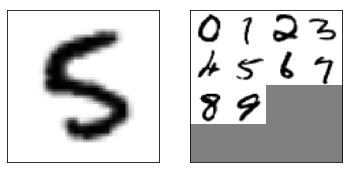

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [118]:
pairs, targets = make_oneshot_task_simplified(5, 70, 10)
plot_oneshot_task(pairs)
print(targets)

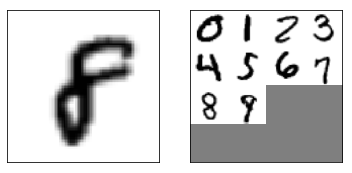

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
8
8


In [121]:
test_number = randrange(10)
test_number_index = randrange(100)

# pairs, targets = make_oneshot_task_simplified(test_number, test_number_index, 10)
# plot_oneshot_task(pairs)
# print(targets)

probs_final = np.zeros((10,1))
for shot in range(10):
    pairs, targets = make_oneshot_task_simplified(test_number, test_number_index, 10)
    probs = cap_model.predict(pairs)
    probs_final += probs
print(test_number)
print(np.argmax(probs_final))


In [122]:
n_rounds = 500
shots = 3

def test_nshot(model, N, k, shots, verbose=True):
    n_correct = 0
    for test in range(k):
        test_number = randrange(10)
        test_number_index = randrange(100)
        probs_final = np.zeros((10,1))
        for shot in range(shots):
            pairs, targets = make_oneshot_task_simplified(test_number, test_number_index, 10)
            probs = cap_model.predict(pairs)
            probs_final += probs
        if np.argmax(probs_final) == test_number:
            n_correct += 1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct


In [125]:
test_nshot(cap_model, 10, 100, 10)

Got an average of 80.0% 10 way one-shot learning accuracy 



80.0

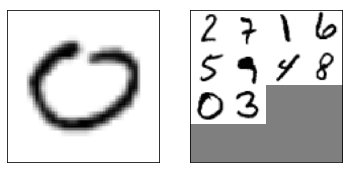

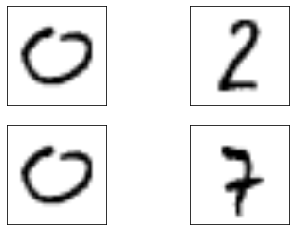

In [38]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(10,"train")
# fig, ax = plt.subplots(nrows=2, ncols=2)
# ax[0][0].matshow(pairs[0][0].reshape(105,105), cmap='gray')
plot_oneshot_task(pairs)
plot_results(pairs[0][0], pairs[1][0],pairs[1][1])

In [25]:
targets

array([0., 1.])

In [43]:
def evaluate():
    pairs, targets = make_oneshot_task(10,"train")
#     plot_oneshot_task(pairs)
    probs1 = cap_model.predict(pairs)
    probs2 = conv_model.predict(pairs)
#     plot_results(pairs[0][0], pairs[1][np.argmax(probs1)], pairs[1][np.argmax(probs2)])
#     print(probs1)
#     print(probs2)
    print ("Cap model : {0}".format(np.argmax(probs1) == np.argmax(targets)))
    print ("Conv model : {0}".format(np.argmax(probs2) == np.argmax(targets)))
    cap_flag = np.argmax(probs1) == np.argmax(targets)
    conv_flag = np.argmax(probs2) == np.argmax(targets)
    if (cap_flag and not conv_flag):
        unique_filename = str(uuid.uuid4())
        plot_oneshot_task(pairs, 'cap_true_conv_false_mnist/{}_task.png'.format(unique_filename))
        plot_results(pairs[0][0], pairs[1][np.argmax(probs1)], pairs[1][np.argmax(probs2)], 'cap_false_conv_true/{}_results.png'.format(unique_filename))
        return True
    else:
        return False


Cap model : False
Conv model : False
Cap model : True
Conv model : True
Cap model : True
Conv model : False


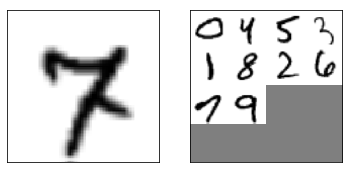

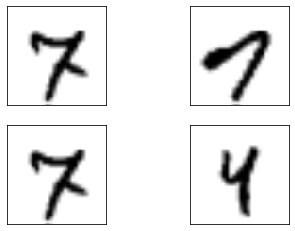

Cap model : False
Conv model : False
Cap model : True
Conv model : False


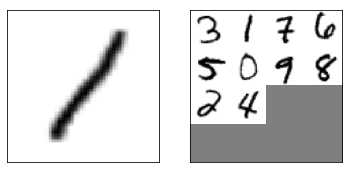

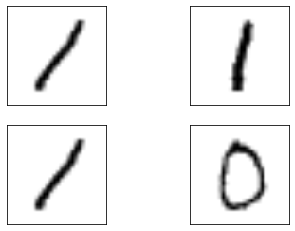

Cap model : True
Conv model : False


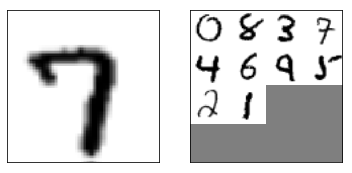

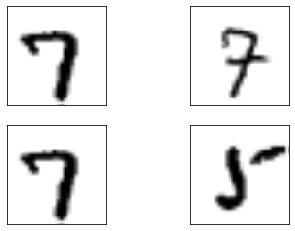

Cap model : True
Conv model : False


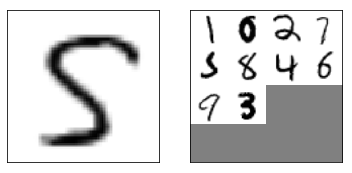

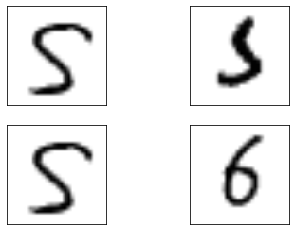

Cap model : False
Conv model : False
Cap model : False
Conv model : False
Cap model : True
Conv model : True
Cap model : False
Conv model : False
Cap model : False
Conv model : False
Cap model : False
Conv model : False
Cap model : True
Conv model : True
Cap model : True
Conv model : True
Cap model : False
Conv model : False
Cap model : False
Conv model : False
Cap model : False
Conv model : False
Cap model : True
Conv model : False


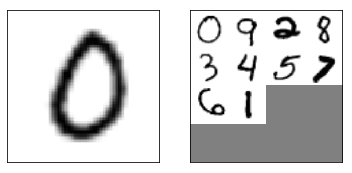

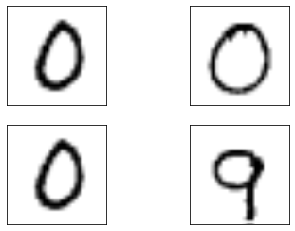

Cap model : True
Conv model : False


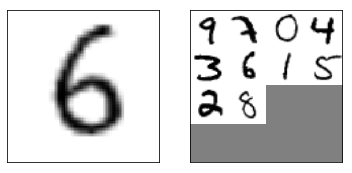

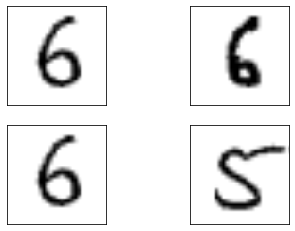

Cap model : True
Conv model : True
Cap model : True
Conv model : True
Cap model : True
Conv model : False


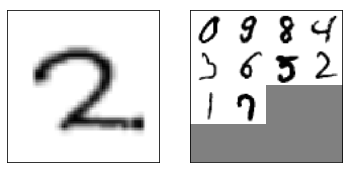

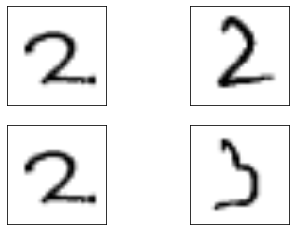

Cap model : True
Conv model : False


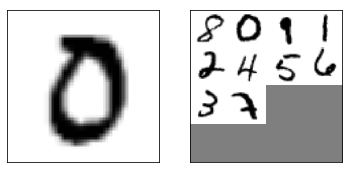

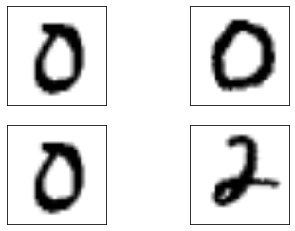

Cap model : False
Conv model : False
Cap model : True
Conv model : True
Cap model : True
Conv model : True
Cap model : True
Conv model : True
Cap model : True
Conv model : False


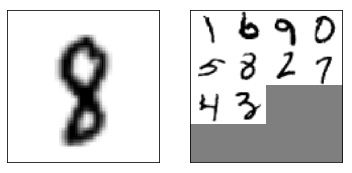

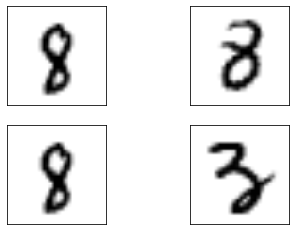

Cap model : False
Conv model : True
Cap model : False
Conv model : False
Cap model : True
Conv model : False


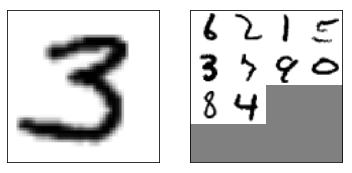

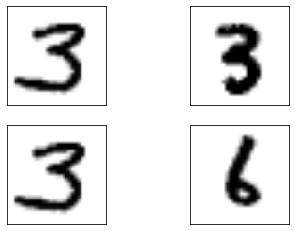

In [45]:
i = 0
while (True):
    if evaluate():
        i += 1
        if i == 10:
            break

In [170]:
probs

array([[1.5699863e-03],
       [2.2065043e-03],
       [7.5604022e-03],
       [5.5338204e-02],
       [2.1690130e-04],
       [4.3748319e-03],
       [8.0204517e-02],
       [4.8643261e-02],
       [9.9960166e-01],
       [2.1278018e-01]], dtype=float32)

In [81]:
probs

array([[0.99978197],
       [0.99978286],
       [0.99978054],
       [0.9997815 ],
       [0.9997827 ],
       [0.99978197],
       [0.999782  ],
       [0.99978215],
       [0.999783  ],
       [0.99978167]], dtype=float32)